In [61]:
import math, datetime, urllib3, re, sys
import ephem as e
import cartopy.crs as ccrs
import os
from skyfield.api import Loader, EarthSatellite, Topos, load
from skyfield.timelib import Time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [43]:
#Two Line Element of ISS
http = urllib3.PoolManager()

#get from Celestrak https://www.celestrak.com/NORAD/elements/stations.txt
TLEurl = 'http://www.celestrak.com/NORAD/elements/stations.txt'
stationsTLE = http.request('GET',TLEurl)
data = stationsTLE.data
stationsTLE_split = str(data).split(r'\r\n')


not_found_count = 0

#find the ISS by looking for the string "1 25544U"
#which is  satellite catalog number = 25544, U = unclassified
#other spacecraft can be used by replacing the cat_num (likely need to change TLE source url too then)
cat_num = "25544U" #including "U" for classification (unclassified)
srch = "1 " + cat_num #add line #1 to search
for n in range(0,(len(stationsTLE_split)-1)):
    if re.search(srch,stationsTLE_split[n]):
        tle0 = stationsTLE_split[n-1]
        tle1 = stationsTLE_split[n]
        tle2 = stationsTLE_split[n+1]
        print('Found most recent ISS TLE from CelesTrak:')
        print('{}\n{}\n{}\n'.format(tle0[2:],tle1,tle2))
    else:
        not_found_count += 1
        
iss = e.readtle(tle0,tle1,tle2)

Found most recent ISS TLE from CelesTrak:
ISS (ZARYA)             
1 25544U 98067A   19130.64742230  .00000880  00000-0  21500-4 0  9990
2 25544  51.6418 187.7475 0001330 335.8559 165.8150 15.52651609169429



In [44]:
#get current ISS location
#compute for current UTC time
iss.compute(datetime.datetime.utcnow())
#print current sub-latitude and sub-longitude point
#convert lat from deg:min:sec to decimal degrees
lat_split = str(iss.sublat).split(":")
lat_deg = float(lat_split[0])
lat_min = float(lat_split[1])
lat_sec = float(lat_split[2])
lat_float = lat_deg + (lat_min/60) + (lat_sec/3600)
#convert lon from deg:min:sec to decimal degrees
lon_split = str(iss.sublong).split(":")
lon_deg = float(lon_split[0])
lon_min = float(lon_split[1])
lon_sec = float(lon_split[2])
lon_float = lon_deg + (lon_min/60) + (lon_sec/3600)
#print lat and lon
print('Current ISS Location: {}, {}'.format(round(lat_float,4), round(lon_float,4)))


Current ISS Location: 32.1553, 119.1918


Point of interest: lat: 37.8, lon: -119.4
Days from now to search: 5
OVERPASS DATE TIME		  LAT	  LON	 SWATH WIDTH(km)
2019-05-12 07:19:04.968360	 38.415	 -121.145	 392.809
2019-05-12 13:48:38.568708	 39.558	 -119.913	 394.005
2019-05-13 06:28:21.334401	 36.055	 -117.912	 392.248
2019-05-15 12:52:39.444945	 38.116	 -121.125	 393.612


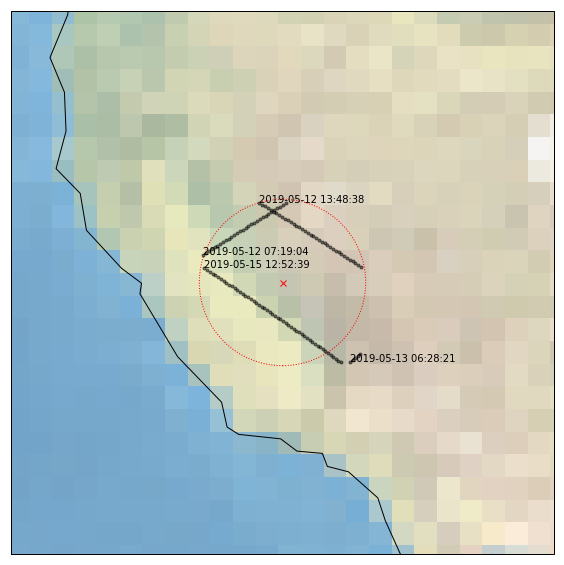

In [102]:
# lat (N+) and lon (E+) for center point of interest.
c_lat = 37.8
c_lon = -119.4

# number of days from now to search
n_days = 5

print('Point of interest: lat: %s, lon: %s' % (c_lat,c_lon))
print('Days from now to search: %s' % n_days)



#set previous month, day, hour all to zero
prev_mon = 0
prev_day = 0
prev_hr = 0
print('OVERPASS DATE TIME\t\t  LAT\t  LON\t SWATH WIDTH(km)')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()


fov = 51

for i in range(0,(n_days*24*60*60)): #number of seconds in n_days
    
    #compute for every minute for the next n_days from right now
    fordate = datetime.datetime.utcnow()+datetime.timedelta(seconds=i)
    iss.compute(fordate)
    
    #calculate actual swath width based on ISS orbit height
    swath_w = (iss.elevation/1000)*(math.tan(math.radians(fov/2)))*2

    
    #ECOSTRESS swath width ~384 km (ISS altitude 400 +/- 25 km)
    #ECOSTRESS FOV 51deg
    #from ground, ISS/ECOSTRESS will be imaging your location if ISS is >65deg above horizon, <25 off zenith
    #also see:https://hyspiri.jpl.nasa.gov/downloads/2014_Workshop/day2/3_ECOSTRESS_Coverage.pdf
    #use the swath_width at this point to calculate the area seen by ECOSTRESS
    #using WGS84 spheroid, convert swath width (km) to deg at specified latitude (c_lat)
    #https://en.wikipedia.org/wiki/Geographic_coordinate_system
    km_per_degLat = (111132.954 - 559.822 * math.cos(2*c_lat) 
                     + 1.175 * math.cos(4*c_lat) 
                     - 0.0023 * math.cos(6*c_lat)) / 1000
    km_per_degLon = (111132.954 * math.cos(c_lat) 
                     - 93.5 * math.cos(3*c_lat) 
                     + 0.118 * math.cos(5*c_lat)) / 1000
    #r = one half of the swath width ("radius") in decimal degrees
    r_lat = (swath_w/km_per_degLat)/2
    r_lon = (swath_w/km_per_degLon)/2
    
    #approximately this box
    min_lat = c_lat - r_lat
    max_lat = c_lat + r_lat
    min_lon = c_lon - r_lon
    max_lon = c_lon + r_lon
    
    
    #print('lat',min_lat,max_lat)
    #print('lon',min_lon,max_lon)
    
    #get the sub lat and lon point in decimal degrees
    #convert lat from deg:min:sec to decimal degrees
    lat_split = str(iss.sublat).split(":")
    lat_deg = float(lat_split[0])
    lat_min = float(lat_split[1])
    lat_sec = float(lat_split[2])
    lat_float = abs(lat_deg) + (lat_min/60) + (lat_sec/3600)
    if float(iss.sublat) < 0:
        lat_float = lat_float * -1
    #convert lon from deg:min:sec to decimal degrees
    lon_split = str(iss.sublong).split(":")
    lon_deg = float(lon_split[0])
    lon_min = float(lon_split[1])
    lon_sec = float(lon_split[2])
    lon_float = abs(lon_deg) + (lon_min/60) + (lon_sec/3600)
    if float(iss.sublong) < 0:
        lon_float = lon_float * -1
        
    #check to see if the ISS will overfly anywhere within the area described above
    if min_lat < lat_float < max_lat:
        if min_lon < lon_float < max_lon:
            #then ISS is covering this area
            #get only unique ISS overpasses
            curr_mon = int(fordate.month)
            curr_day = int(fordate.day)
            curr_hr = int(fordate.hour)
            ax.plot(lon_float,lat_float,'.k',alpha=0.5)
            if curr_mon == prev_mon and curr_day == prev_day and curr_hr == prev_hr:
                pass
            else:
                print('{}\t {}\t {}\t {}'.format(fordate, 
                                                 np.round(lat_float,3), 
                                                 np.round(lon_float,3), 
                                                 np.round(swath_w,3)))
                ax.text(lon_float,lat_float,str(fordate)[:-7])
                #set the current month,day,hour to previous before moving on
                prev_mon = curr_mon
                prev_day = curr_day
                prev_hr = curr_hr

plt.plot(c_lon,c_lat,'xr')                
plt.xlim((c_lon-6,c_lon+6))
plt.ylim((c_lat-6,c_lat+6))

circle = plt.Circle((c_lon,c_lat), (r_lat+r_lon)/2 , linestyle=':', color='r', fill=False)
ax.add_artist(circle)

plt.show()

***

In [74]:
def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 

    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)

            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw

***
***

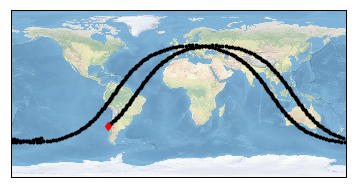

In [75]:
L1 = tle1
L2 = tle2



halfpi, pi, twopi = [f*np.pi for f in (0.5, 1, 2)]
degs, rads = 180/pi, pi/180

ts   = load.timescale()

sat = EarthSatellite(L1, L2)

#print(sat.epoch.tt)
hours = np.arange(0, 3, 0.01)
y = datetime.datetime.utcnow().year
m = datetime.datetime.utcnow().month
d = datetime.datetime.utcnow().day
time = ts.utc(y, m, d, hours)

sat_pos    = sat.at(time).position.km
sat_posecl = sat.at(time).ecliptic_position().km



ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines()
ax.stock_img()



# Where is satellite in lat/lon over the time range?
geocentric = sat.at(time)

subpoint = geocentric.subpoint()
sat_lat = np.degrees(subpoint.latitude.radians)
sat_lon = np.degrees(subpoint.longitude.radians)
ax.plot(sat_lon,sat_lat,'.k')


# Where is the satellite in lat/lon NOW?
geocentric = sat.at(ts.now())
subpoint = geocentric.subpoint()
sat_lat = np.degrees(subpoint.latitude.radians)
sat_lon = np.degrees(subpoint.longitude.radians)

ax.plot(sat_lon,sat_lat,'dr')




plt.show()
